In [64]:
from __future__ import absolute_import, division, print_function, unicode_literals
import tensorflow as tf

import matplotlib as mpl
import matplotlib.pyplot as plt
import numpy as np
import os
import pandas as pd

mpl.rcParams['figure.figsize'] = (8, 6)
mpl.rcParams['axes.grid'] = False

In [65]:
df = pd.read_csv("Train_TEC_mar17.csv")
df.head()

,Date,Month,Year,Time,LT,TEC
0,1,3,2017,0.016389,5.311333,2.067562
1,1,3,2017,0.049722,5.344670,2.082707
2,1,3,2017,0.083056,5.378006,2.004272
3,1,3,2017,0.116389,5.411343,1.736569
4,1,3,2017,0.149722,5.444679,1.758503


In [66]:
def univariate_data(dataset, start_index, end_index, history_size, target_size):
  data = []
  labels = []

  start_index = start_index + history_size
  if end_index is None:
    end_index = len(dataset) - target_size

  for i in range(start_index, end_index):
    indices = range(i-history_size, i)
    # Reshape data from (history_size,) to (history_size, 1)
    data.append(np.reshape(dataset[indices], (history_size, 1)))
    labels.append(dataset[i+target_size])
  return np.array(data), np.array(labels)

In [67]:
TRAIN_SPLIT = 12960

In [68]:
tf.random.set_seed(42)

In [69]:
tec_data = df["TEC"]
tec_data.head()

0    2.067562
1    2.082707
2    2.004272
3    1.736569
4    1.758503
Name: TEC, dtype: float64

array([<matplotlib.axes._subplots.AxesSubplot object at 0x000002118B57BD48>],
      dtype=object)

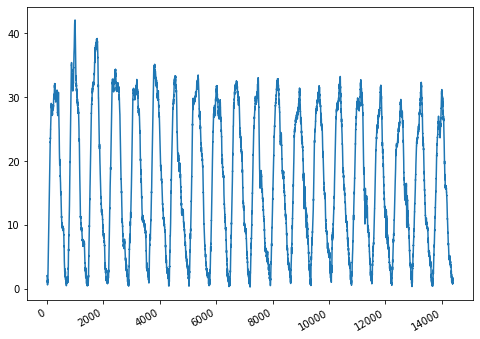

In [70]:
tec_data.plot(subplots=True)

In [71]:
tec_data = tec_data.values

In [72]:
tec_data_mean = tec_data[:TRAIN_SPLIT].mean()
tec_data_std = tec_data[:TRAIN_SPLIT].std()

In [73]:
tec_data = (tec_data-tec_data_mean)/tec_data_std

In [74]:
tec_past_data = 20
tec_future_target = 0

x_train_tec, y_train_tec = univariate_data(tec_data, 0, TRAIN_SPLIT,
                                           tec_past_data,
                                           tec_future_target)
x_val_tec, y_val_tec = univariate_data(tec_data, TRAIN_SPLIT, None,
                                       tec_past_data,
                                       tec_future_target)

In [75]:
print ('Single window of past history')
print (x_train_tec[0])
print ('\n Target TEC to predict')
print (y_train_tec[0])

Single window of past history
[[-1.39848606]
 [-1.39708702]
 [-1.40433257]
 [-1.42906196]
 [-1.42703578]
 [-1.44636274]
 [-1.42862565]
 [-1.46376429]
 [-1.49199263]
 [-1.48367203]
 [-1.49375948]
 [-1.46969347]
 [-1.46793311]
 [-1.47223212]
 [-1.5005602 ]
 [-1.53244351]
 [-1.49816913]
 [-1.48757984]
 [-1.49600113]
 [-1.49409268]]

 Target TEC to predict
-1.4810745512554635


In [76]:
def create_time_steps(length):
  return list(range(-length, 0))

In [77]:
def show_plot(plot_data, delta, title):
  labels = ['History', 'True Future', 'Model Prediction']
  marker = ['.-', 'rx', 'go']
  time_steps = create_time_steps(plot_data[0].shape[0])
  if delta:
    future = delta
  else:
    future = 0

  plt.title(title)
  for i, x in enumerate(plot_data):
    if i:
      plt.plot(future, plot_data[i], marker[i], markersize=10,
               label=labels[i])
    else:
      plt.plot(time_steps, plot_data[i].flatten(), marker[i], label=labels[i])
  plt.legend()
  plt.xlim([time_steps[0], (future+5)*2])
  plt.xlabel('Time-Step')
  return plt

<module 'matplotlib.pyplot' from 'C:\\Users\\yash\\Miniconda3\\envs\\TEC\\lib\\site-packages\\matplotlib\\pyplot.py'>

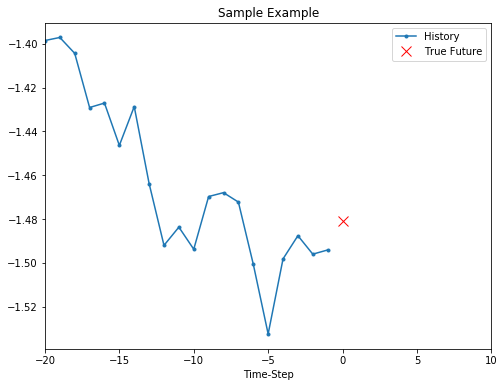

In [78]:
show_plot([x_train_tec[0], y_train_tec[0]], 0, 'Sample Example')

In [79]:
def baseline(history):
  return np.mean(history)

<module 'matplotlib.pyplot' from 'C:\\Users\\yash\\Miniconda3\\envs\\TEC\\lib\\site-packages\\matplotlib\\pyplot.py'>

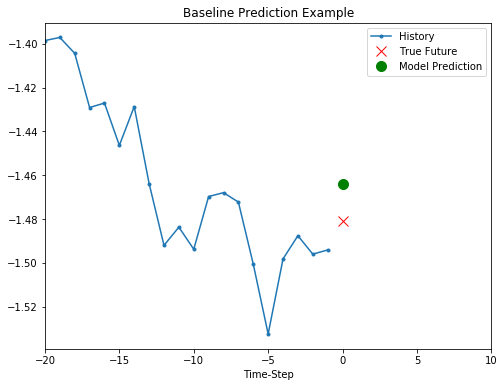

In [81]:
show_plot([x_train_tec[0], y_train_tec[0], baseline(x_train_tec[0])], 0,
           'Baseline Prediction Example')

In [82]:
BATCH_SIZE = 256
BUFFER_SIZE = 10000

train_univariate = tf.data.Dataset.from_tensor_slices((x_train_tec, y_train_tec))
train_univariate = train_univariate.cache().shuffle(BUFFER_SIZE).batch(BATCH_SIZE).repeat()

val_univariate = tf.data.Dataset.from_tensor_slices((x_val_tec, y_val_tec))
val_univariate = val_univariate.batch(BATCH_SIZE).repeat()

In [84]:
simple_lstm_model = tf.keras.models.Sequential([
    tf.keras.layers.LSTM(8, input_shape=x_train_tec.shape[-2:]),
    tf.keras.layers.Dense(1)
])

simple_lstm_model.compile(optimizer='adam', loss='mae')

In [85]:
for x, y in val_univariate.take(1):
    print(simple_lstm_model.predict(x).shape)

(256, 1)


In [86]:
EVALUATION_INTERVAL = 200
EPOCHS = 25

simple_lstm_model.fit(train_univariate, epochs=EPOCHS,
                      steps_per_epoch=EVALUATION_INTERVAL,
                      validation_data=val_univariate, validation_steps=50)

Train for 200 steps, validate for 50 steps
Epoch 1/25
200/200 [==============================] - 15s 73ms/step - loss: 0.2946 - val_loss: 0.0588
Epoch 2/25
200/200 [==============================] - 10s 49ms/step - loss: 0.0425 - val_loss: 0.0256
Epoch 3/25
200/200 [==============================] - 10s 49ms/step - loss: 0.0290 - val_loss: 0.0217
Epoch 4/25
200/200 [==============================] - 10s 48ms/step - loss: 0.0252 - val_loss: 0.0206
Epoch 5/25
200/200 [==============================] - 10s 50ms/step - loss: 0.0237 - val_loss: 0.0199
Epoch 6/25
200/200 [==============================] - 10s 50ms/step - loss: 0.0225 - val_loss: 0.0195
Epoch 7/25
200/200 [==============================] - 10s 49ms/step - loss: 0.0219 - val_loss: 0.0194
Epoch 8/25
200/200 [==============================] - 9s 47ms/step - loss: 0.0212 - val_loss: 0.0186
Epoch 9/25
200/200 [==============================] - 9s 47ms/step - loss: 0.0206 - val_loss: 0.0184
Epoch 10/25
200/200 [====================

[-1.135259]


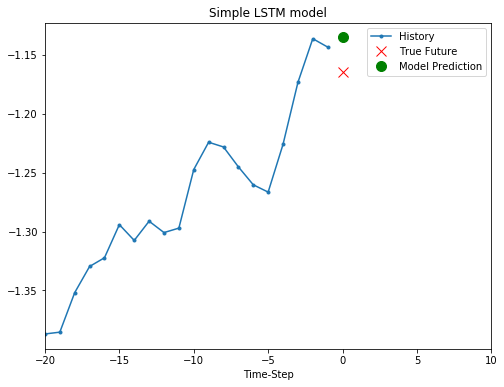

[1.1031939]


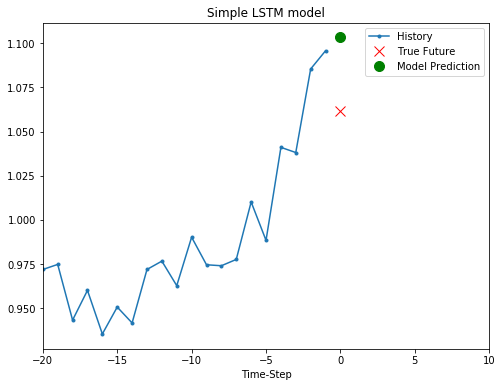

[-0.71129346]


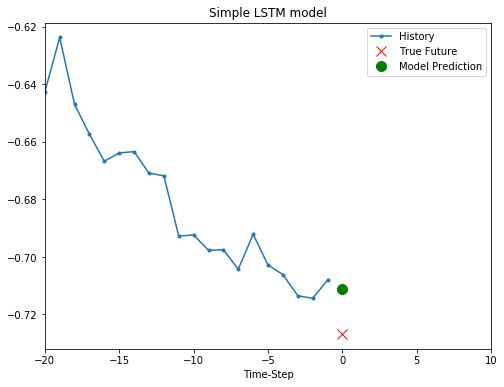

In [88]:
for x, y in val_univariate.take(3):
  plot = show_plot([x[0].numpy(), y[0].numpy(),
                    simple_lstm_model.predict(x)[0]], 0, 'Simple LSTM model')
  print(simple_lstm_model.predict(x)[0])
  plot.show()

In [ ]:
|